# Extending analysis to non-normal specimens

This notebook will explore the non-normal specimens.

## 0. Initializations

In [10]:
# -- imports --
from pathlib import Path

import anndata as ad
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

from scipy import sparse

from signals_in_the_noise.preprocessing.gse161529 import GSE161529
from signals_in_the_noise.utilities.storage import get_data_path, get_resources_path
from signals_in_the_noise.utilities.visualization import get_figure_axes

In [2]:
# -- datasets --
gse = GSE161529()

2025-07-28 23:05:04,431 [INFO] signals_in_the_noise.utilities.tenx_genomics: Reading C:\Users\silly\GitHub\signals-in-the-noise\data\GSE161529_adata_cache\GSM4909253_N-PM0092-Total.h5ad as AnnData object.
2025-07-28 23:05:04,532 [INFO] signals_in_the_noise.utilities.tenx_genomics: Reading C:\Users\silly\GitHub\signals-in-the-noise\data\GSE161529_adata_cache\GSM4909254_N-PM0019-Total.h5ad as AnnData object.
2025-07-28 23:05:04,695 [INFO] signals_in_the_noise.utilities.tenx_genomics: Reading C:\Users\silly\GitHub\signals-in-the-noise\data\GSE161529_adata_cache\GSM4909255_N-N280-Epi.h5ad as AnnData object.
2025-07-28 23:05:04,753 [INFO] signals_in_the_noise.utilities.tenx_genomics: Reading C:\Users\silly\GitHub\signals-in-the-noise\data\GSE161529_adata_cache\GSM4909256_N-PM0095-Epi.h5ad as AnnData object.
2025-07-28 23:05:04,901 [INFO] signals_in_the_noise.utilities.tenx_genomics: Reading C:\Users\silly\GitHub\signals-in-the-noise\data\GSE161529_adata_cache\GSM4909257_N-PM0095-Total.h5ad 

## 1. Combine datasets

In [5]:
filenames = {
    "B1-0894": "GSM4909277_B1-KCF0894.h5ad",
    "B1-0033": "GSM4909278_B1-MH0033.h5ad",
    "B1-0023": "GSM4909279_B1-MH0023.h5ad",
}
hvg_only=True
hvg_post_stromal=True
apply_tsne=True
genes_to_check=None

In [18]:
all_real_filename = get_data_path("combined_epi_not_normal_real.h5ad")
all_noise_filename = get_data_path("combined_epi_not_normal_noise.h5ad")

all_real_path = Path(all_real_filename)
all_noise_path = Path(all_noise_filename)

# if all([all_real_path.exists(), all_noise_path.exists()]):
if False:
    print("Loading combined datasets...")
    adatas_all_real = ad.read_h5ad(all_real_filename)
    adatas_all_noise = ad.read_h5ad(all_noise_filename)
else:
    print("Combining datasets...")
    adatas_real = []
    adatas_noise = []
    for idx, (specimen_id, filename) in enumerate(filenames.items()):
        adata = gse.get_dataset(filename)
        adata.obs_names = [f"{filename}_{i}" for i in range(adata.n_obs)]

        for is_noise in (0, 1):
            adata_subset = adata[adata.obs['is_noise'] == is_noise].copy()
            if genes_to_check:
                missing = gse._check_adata_for_genes(adata_subset, genes_to_check)
                print(f"[before annotation] Sanity check genes missing ({len(missing)}) {', '.join(missing)}")
            adata_subset = gse._cache_combined_epithilial_gene_expression(adata_subset)
            adata_subset = gse.annotate_epithial_cell_typing(adata_subset, hvg_only=hvg_only)
            # remove stromal cells - "...removed the stromal subset..."
            mask = ~adata_subset.obs['predicted_type'].str.lower().str.contains('stromal')
            adata_subset = adata_subset[mask].copy()
            if hvg_only and hvg_post_stromal:
                sc.pp.highly_variable_genes(adata_subset)
                adata_subset.raw = adata_subset.copy()
                adata_subset = adata_subset[:, adata_subset.var['highly_variable']].copy()

            if genes_to_check:
                missing = gse._check_adata_for_genes(adata_subset, genes_to_check)
                print(f"[after stromal filter], sanity check genes missing ({len(missing)}) {', '.join(missing)}")

            # additional features for visualizations
            adata_subset.obs['specimen_id'] = specimen_id
            adata_subset.obs['hormonal_status'] = adata_subset.uns['menopause_status']
            adata_subset.obs['cancer_type'] = adata_subset.uns['cancer_type']
            adata_subset.obs['cell_population'] = adata_subset.uns['cell_population']
            adata_subset.obs['gender'] = adata_subset.uns['gender']
            adata_subset.obs['parity'] = adata_subset.uns['parity']
            # just in case
            if sparse.issparse(adata_subset.X):
                adata_subset.X = adata_subset.X.toarray()

            if not is_noise:
                adatas_real.append(adata_subset)
            else:
                adatas_noise.append(adata_subset)

    adatas_all_real = ad.concat(adatas_real, join='inner')
    adatas_all_noise = ad.concat(adatas_noise, join='inner')

    if apply_tsne and hvg_post_stromal:
        # reduce dimensions
        gse.apply_tsne(adatas_all_real, resolution=0.15, n_comps=20, use_leiden=False)
        gse.apply_tsne(adatas_all_noise, resolution=0.15,  n_comps=4, use_leiden=False)

    if apply_tsne and not hvg_post_stromal:
        # reduce dimensions
        gse.apply_tsne(adatas_all_real)
        gse.apply_tsne(adatas_all_noise)

    # write out the combined datasets
    adatas_all_real.write(all_real_filename)
    adatas_all_noise.write(all_noise_filename)

Combining datasets...
Log normalizing dataset...
Filtering dataset to highly variable genes...
Log normalizing dataset...
Filtering dataset to highly variable genes...
Log normalizing dataset...
Filtering dataset to highly variable genes...
Log normalizing dataset...
Filtering dataset to highly variable genes...
Log normalizing dataset...
Filtering dataset to highly variable genes...
Log normalizing dataset...
Filtering dataset to highly variable genes...


2025-07-28 23:30:11,502 [INFO] openTSNE.tsne: Precomputed initialization provided. Ignoring initalization-related parameters.
2025-07-28 23:30:11,510 [INFO] openTSNE.tsne: Automatically determined negative gradient method `fft`
2025-07-28 23:30:15,691 [INFO] openTSNE.tsne: Automatically determined negative gradient method `fft`
2025-07-28 23:30:54,588 [INFO] openTSNE.tsne: Precomputed initialization provided. Ignoring initalization-related parameters.
2025-07-28 23:30:54,590 [INFO] openTSNE.tsne: Automatically determined negative gradient method `bh`
2025-07-28 23:31:03,363 [INFO] openTSNE.tsne: Automatically determined negative gradient method `bh`
... storing 'predicted_type' as categorical
... storing 'specimen_id' as categorical
... storing 'hormonal_status' as categorical
... storing 'cancer_type' as categorical
... storing 'cell_population' as categorical
... storing 'gender' as categorical
... storing 'parity' as categorical
... storing 'predicted_type' as categorical
... storin

## 2. TSNE Visualizations

### 2.a. "Real" cells

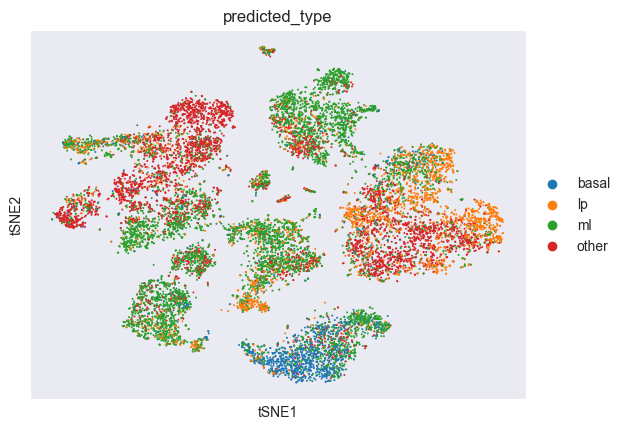

In [19]:
gse.visualize_tsne(adatas_all_real, color=['predicted_type'])

### 2.b. "Noise" cells

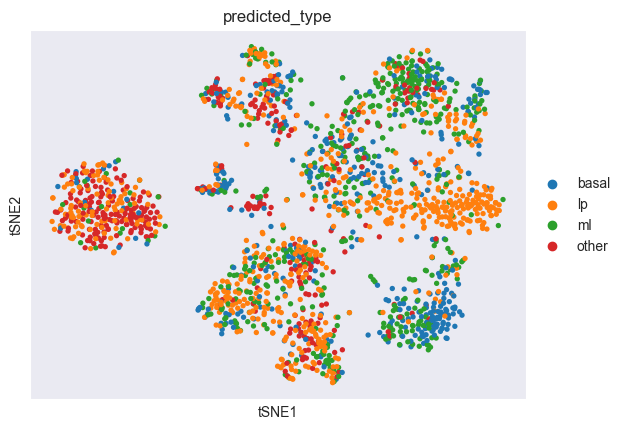

In [22]:
gse.visualize_tsne(adatas_all_noise, color=['predicted_type'])